In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("WineQT.csv", sep=",")
df = df.drop(columns="Id")
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar   
count    1143.000000       1143.000000  1143.000000     1143.000000  \
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density   
count  1143.000000          1143.000000           1143.000000  1143.000000  \
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

In [3]:
def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

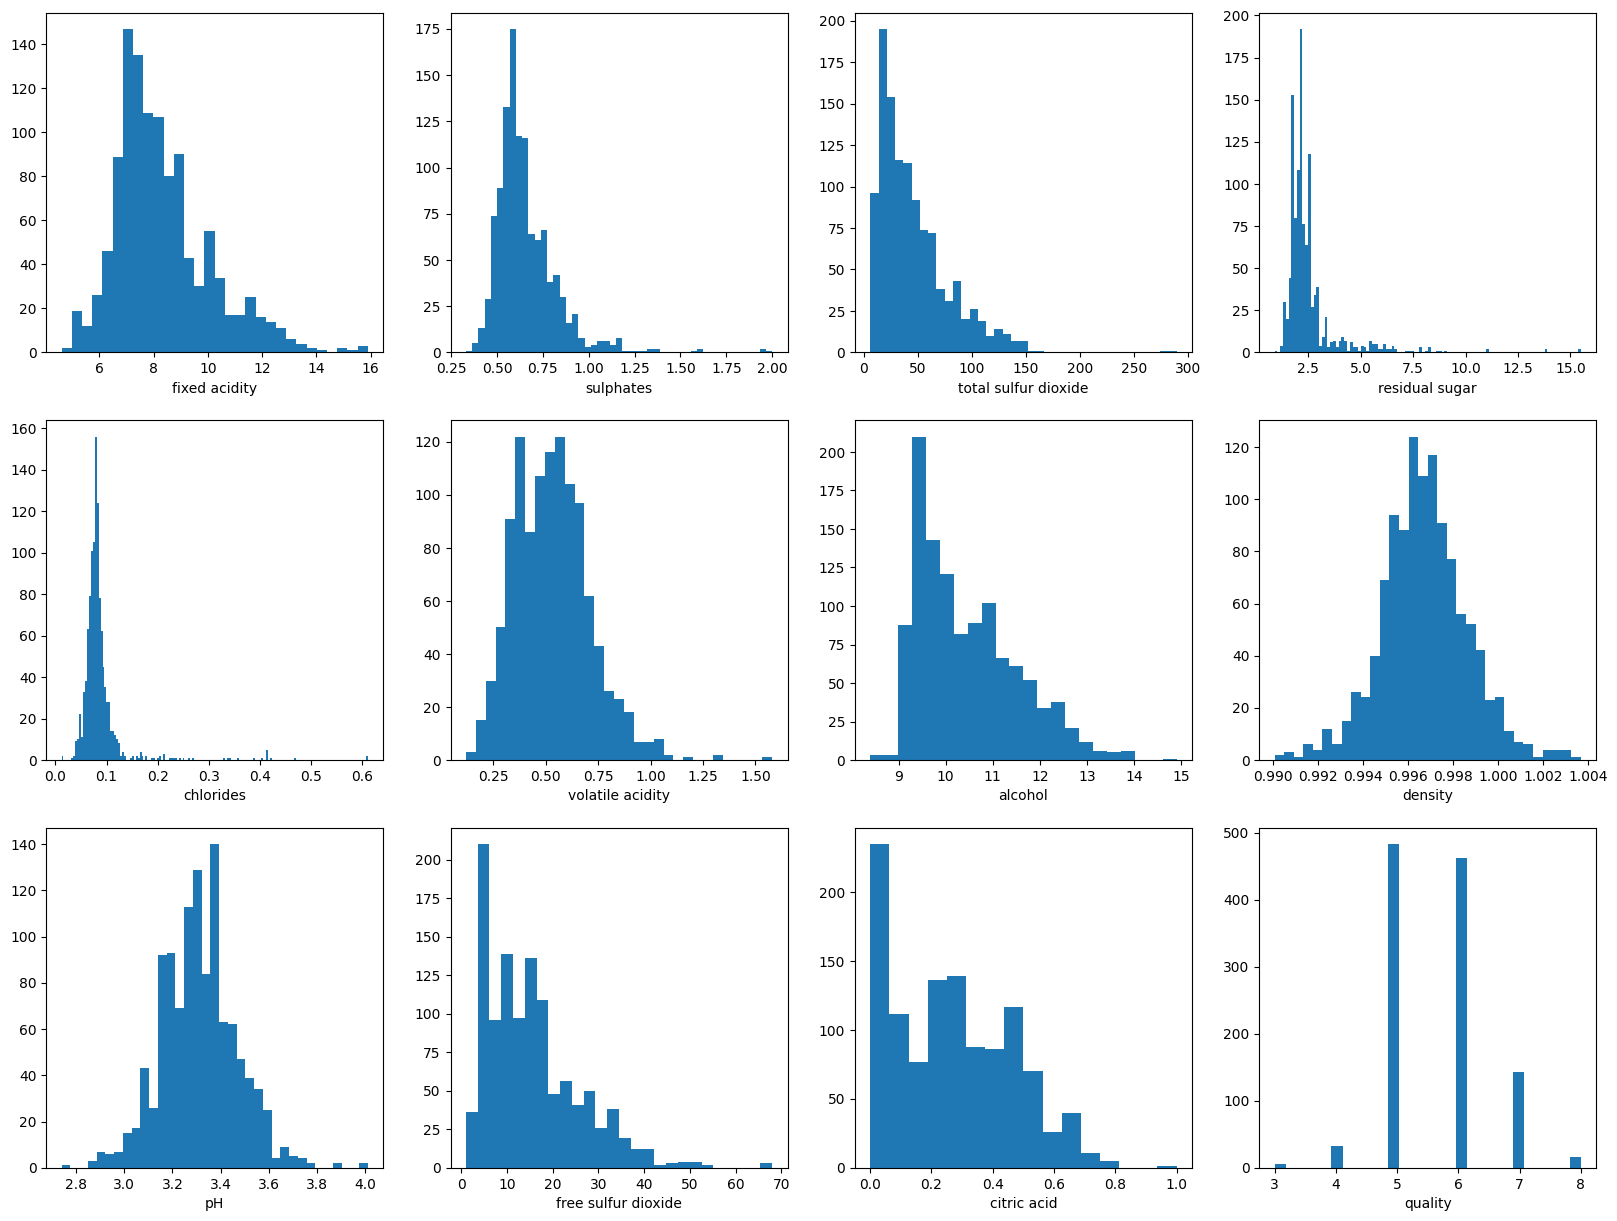

In [4]:
plot_hists(df)

C:\Users\ktabakh\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


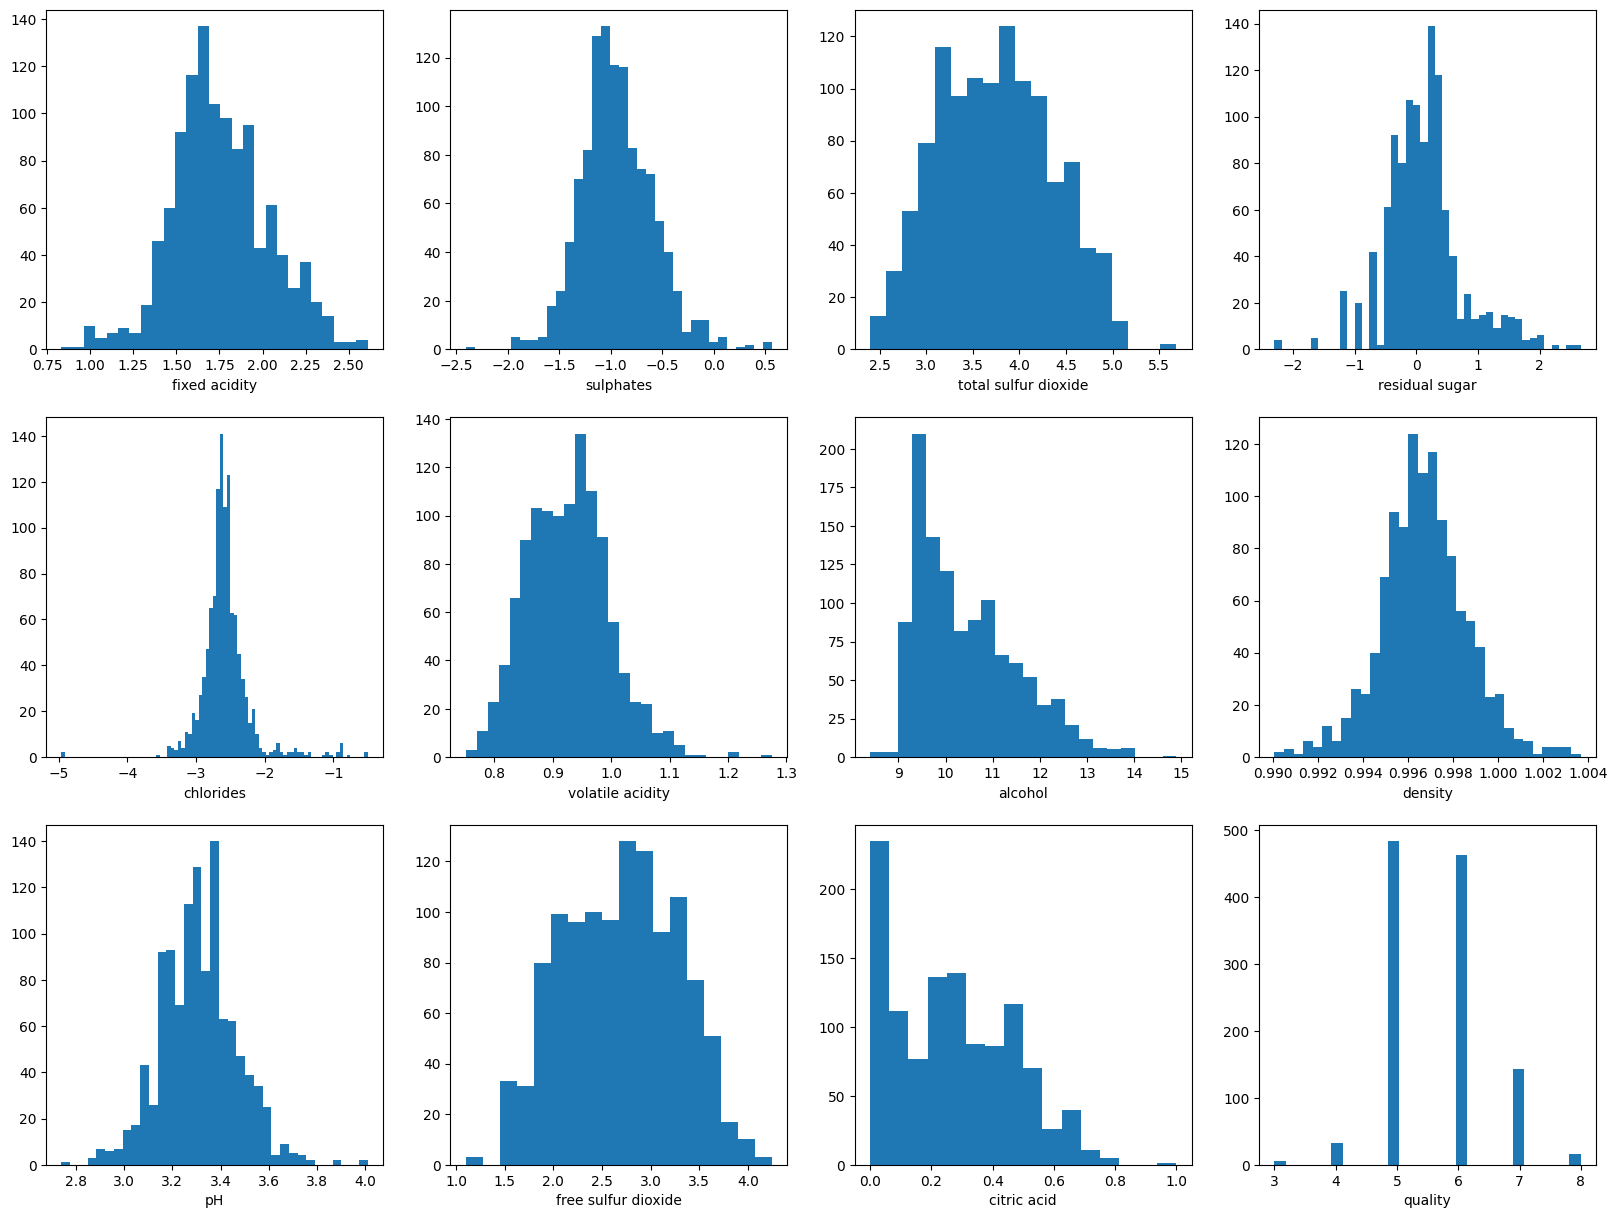

In [5]:
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)

normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
plot_hists(df)

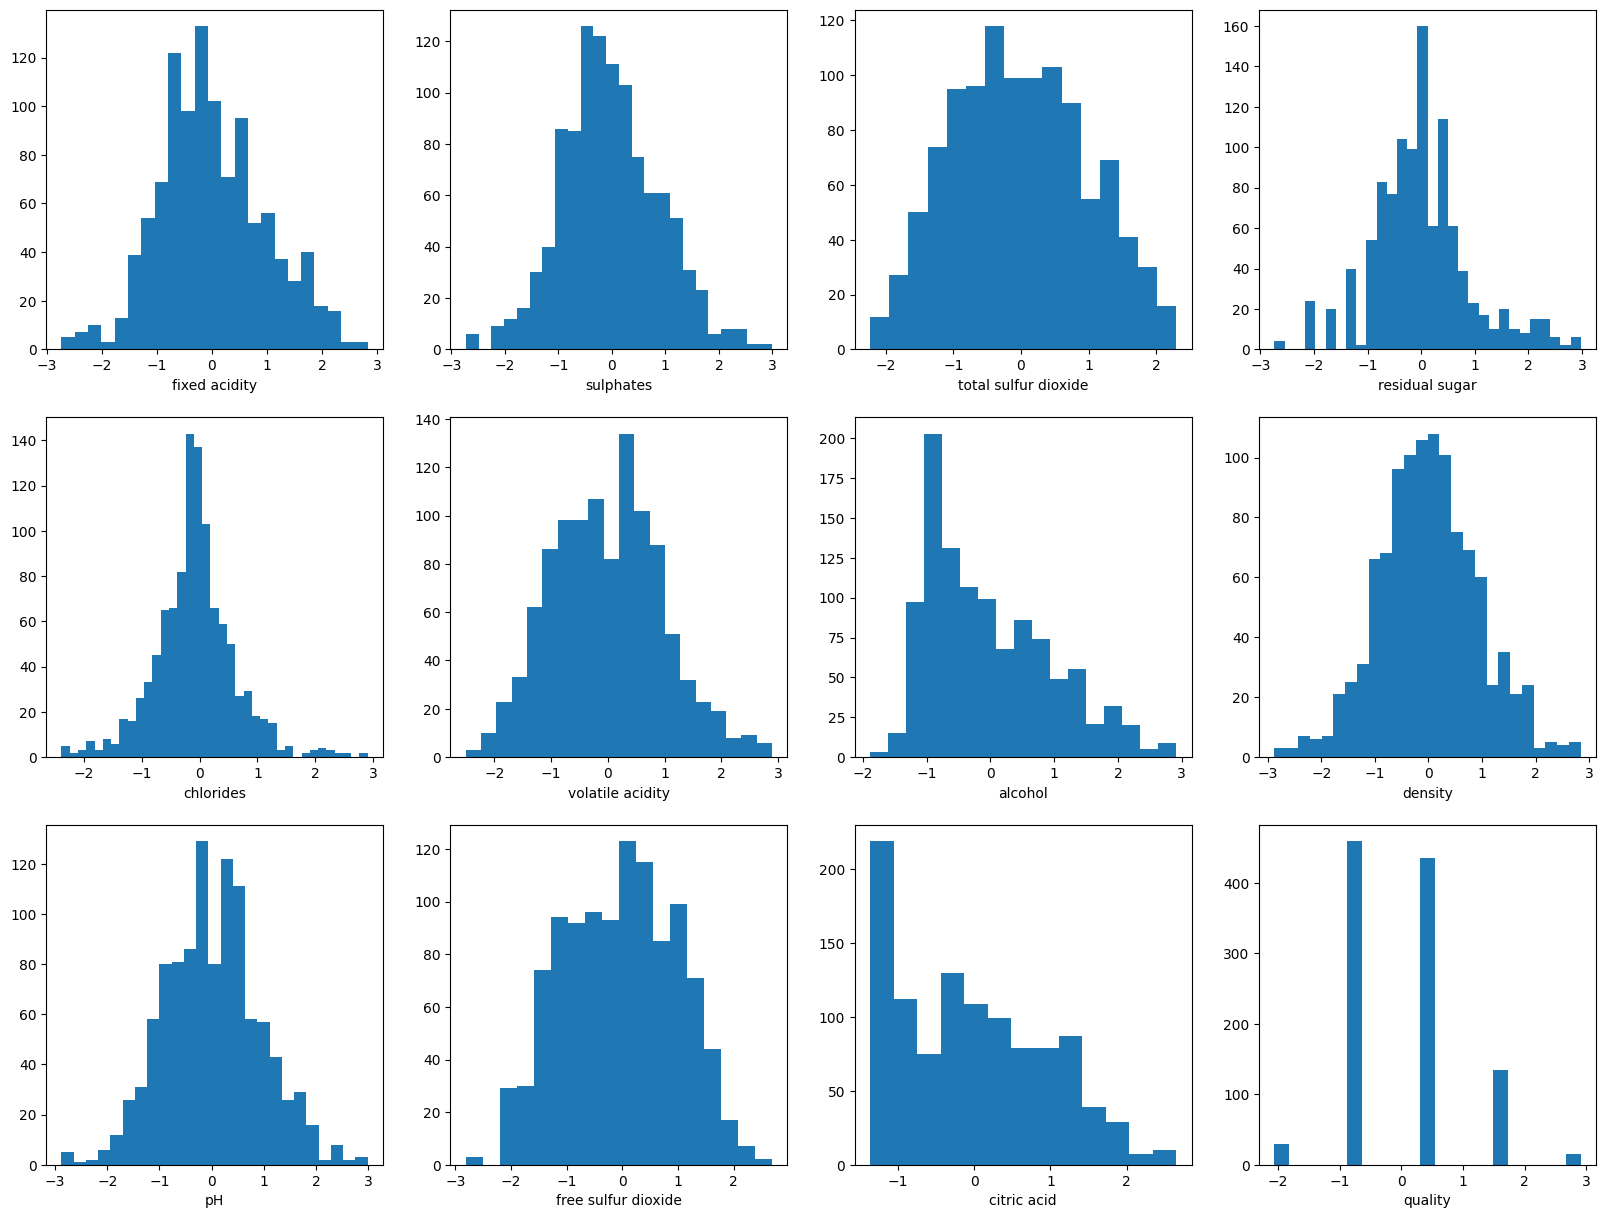

In [6]:
standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
plot_hists(standardized)

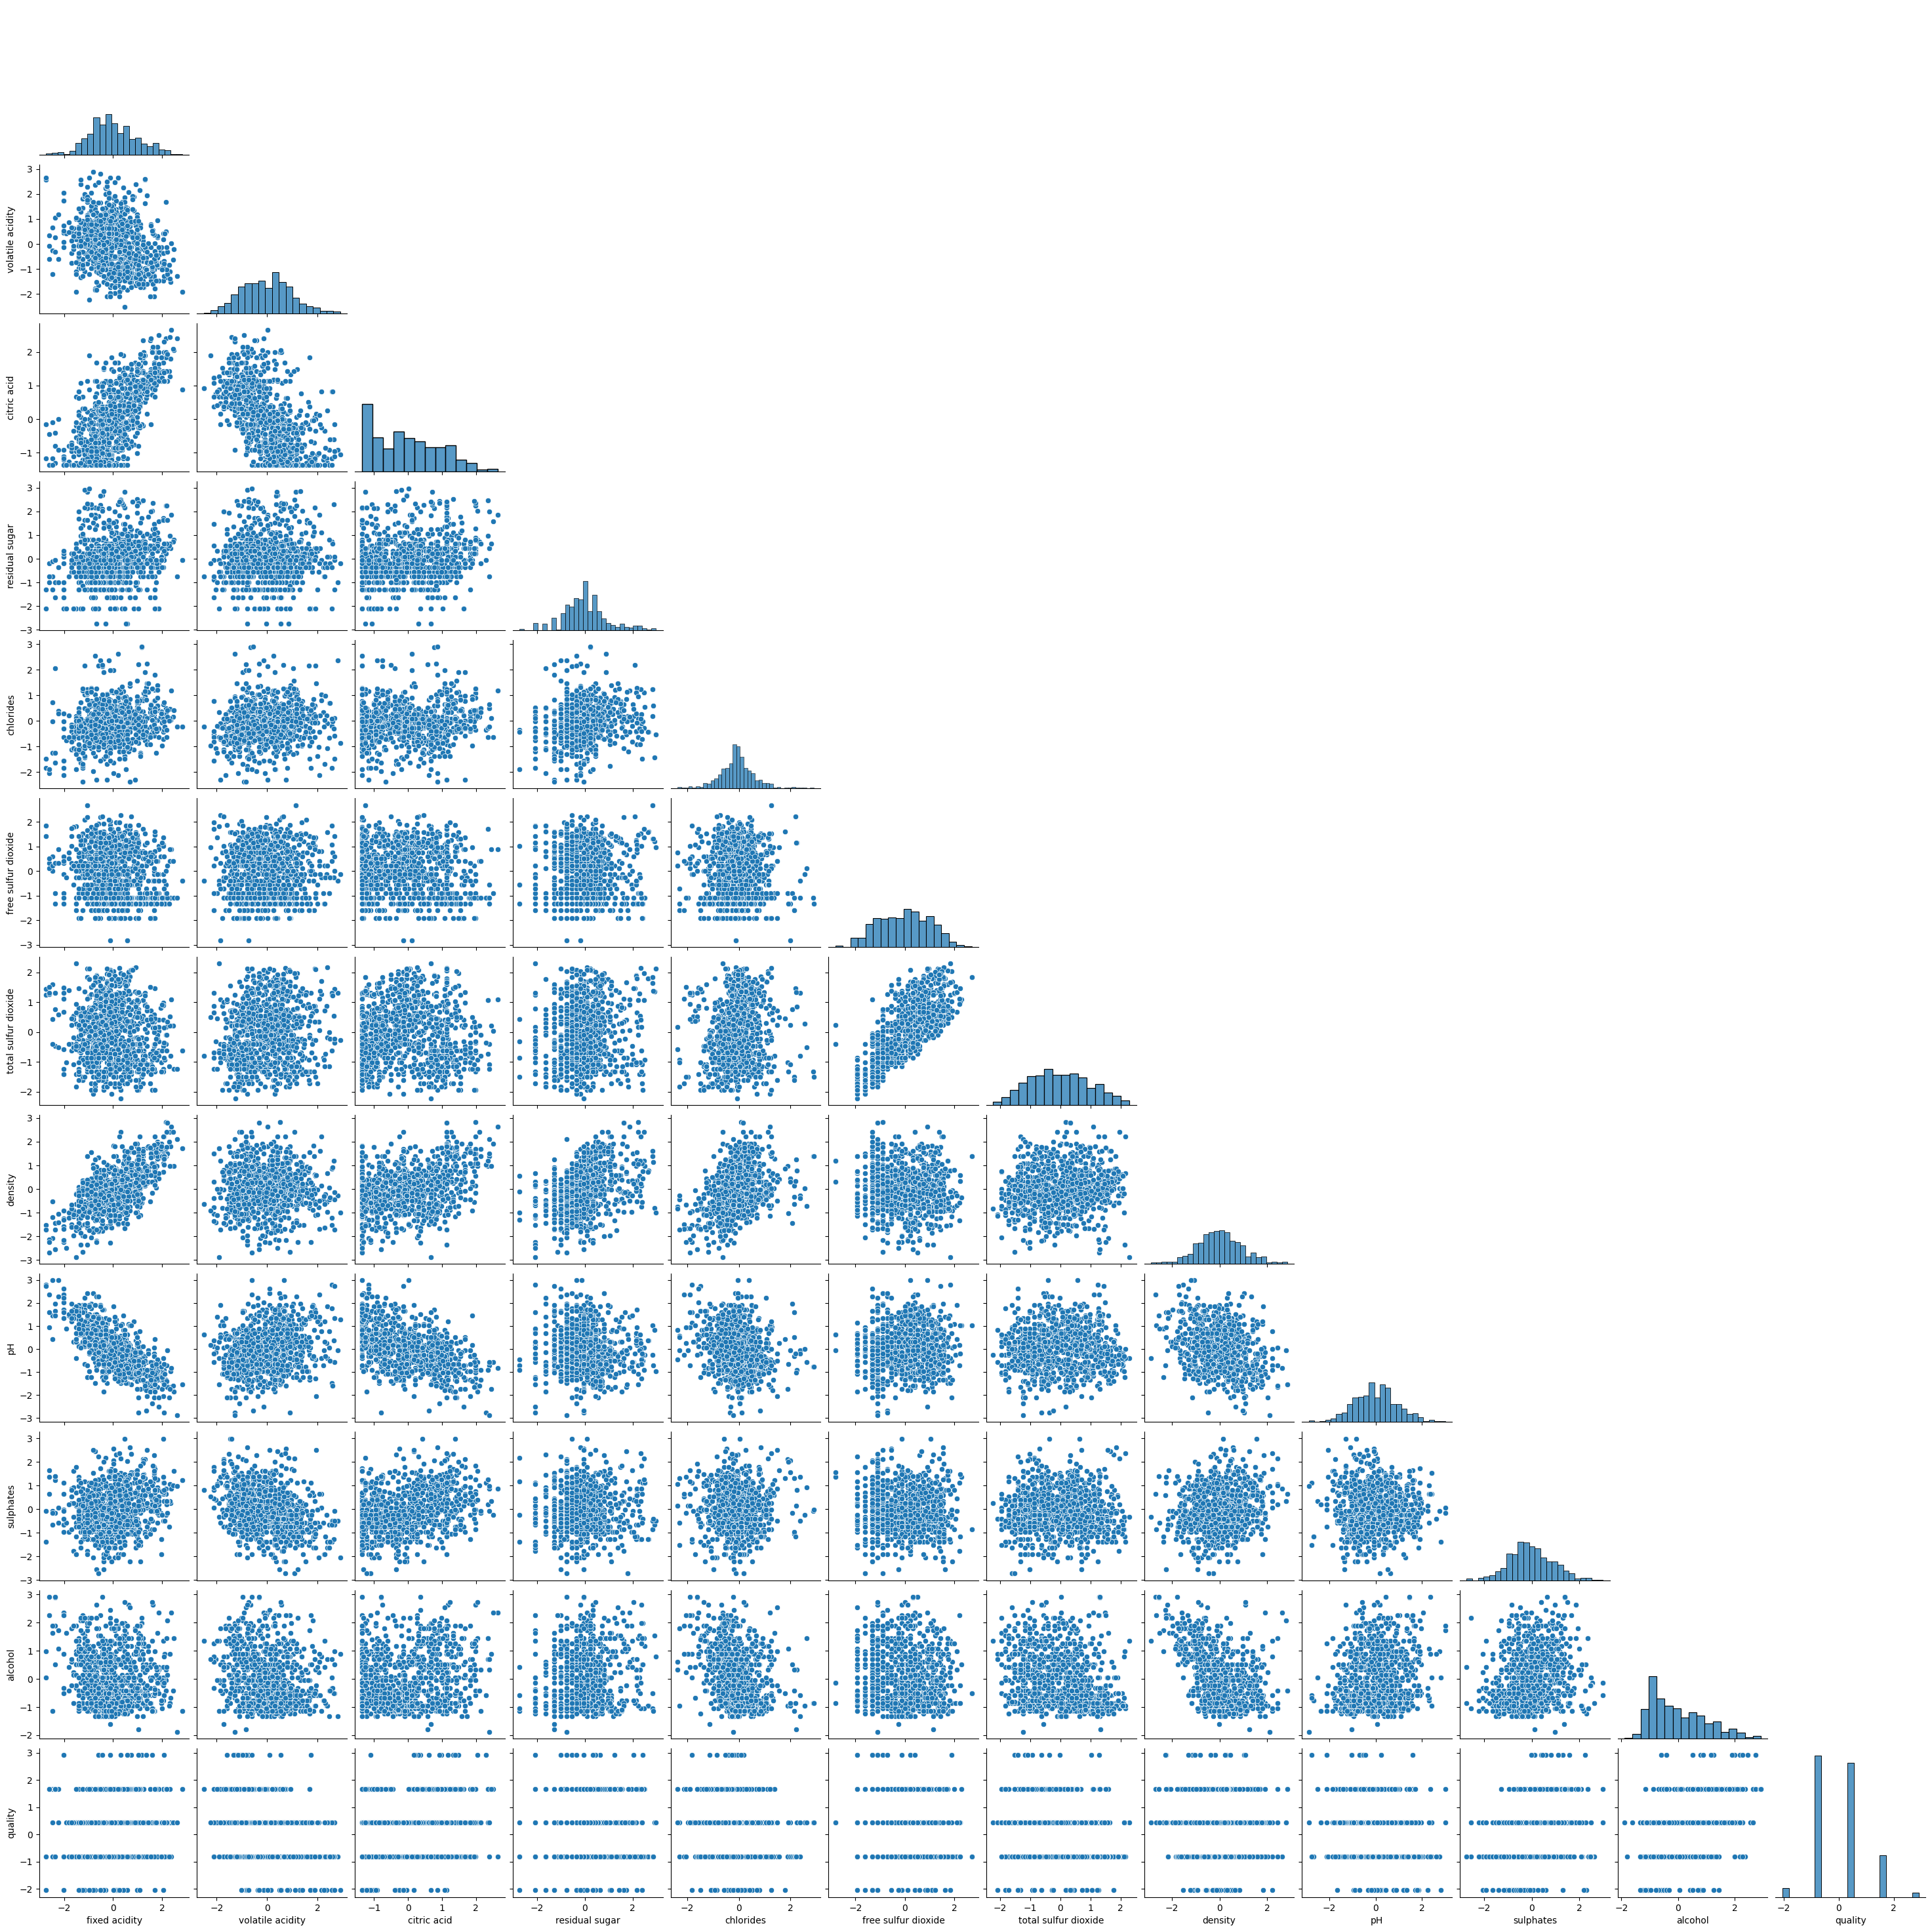

In [7]:
sns.pairplot(standardized, corner=True)

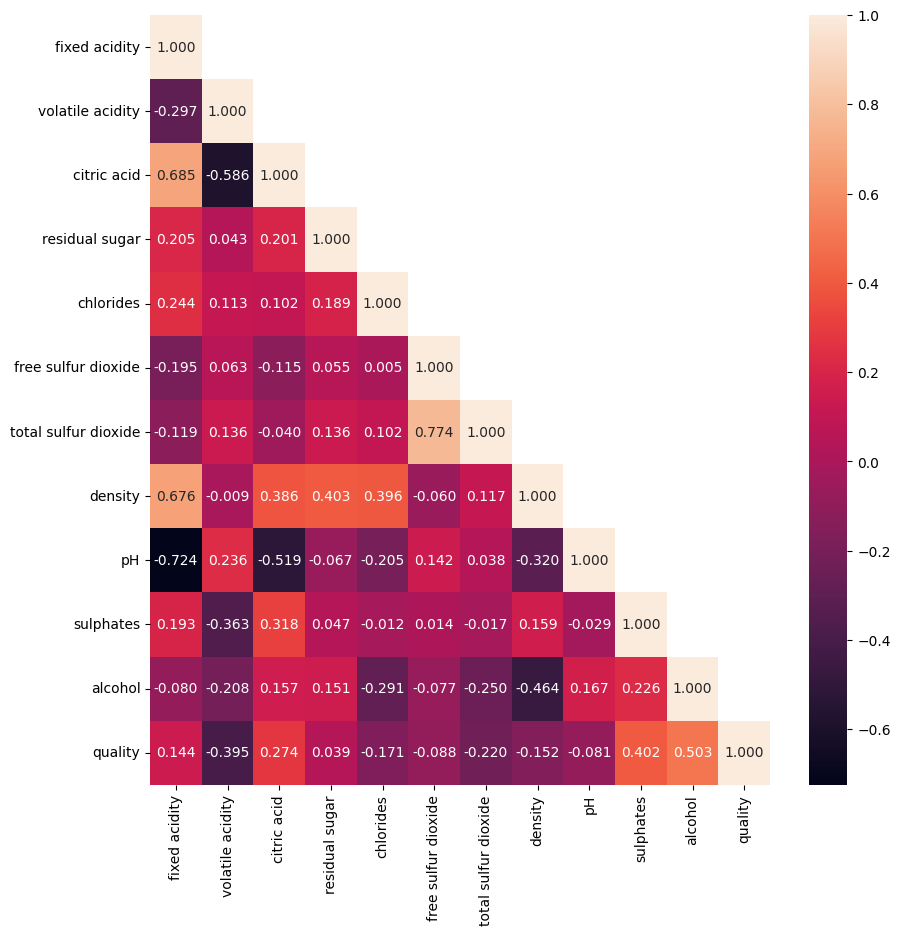

In [8]:
corr = standardized.corr()
matrix = np.triu(corr, 1)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr, annot=True, fmt=".3f", mask=matrix)

In [9]:
df = df.drop(columns=["fixed acidity", "total sulfur dioxide"])
df = df.loc[standardized.index]
print(df.describe())

       volatile acidity  citric acid  residual sugar    chlorides   
count       1074.000000  1074.000000     1074.000000  1074.000000  \
mean           0.925244     0.262793        0.117516    -2.603734   
std            0.067709     0.191576        0.577733     0.242205   
min            0.751416     0.000000       -1.609438    -3.411248   
25%            0.871293     0.090000       -0.223144    -2.733368   
50%            0.924259     0.250000        0.095310    -2.603690   
75%            0.970779     0.420000        0.405465    -2.476938   
max            1.128171     0.790000        2.014903    -1.565421   

       free sulfur dioxide      density           pH    sulphates   
count          1074.000000  1074.000000  1074.000000  1074.000000  \
mean              2.702034     0.996727     3.314674    -0.952988   
std               0.565918     0.001769     0.144323     0.321535   
min               1.098612     0.991200     2.860000    -1.897120   
25%               2.197225     0.

In [10]:
# from sklearn.model_selection import train_test_split

# X = np.c_[df.iloc[:, :-1].to_numpy(), np.ones(df.shape[0])]
# y = df["quality"].to_numpy()

# X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42)
# X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [11]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler().fit(X_train)

# X_train = scaler.transform(X_train)
# X_cv = scaler.transform(X_cv)
# X_test = scaler.transform(X_test)

# w = np.ones(X.shape[1]).reshape(-1, 1)
# f = lambda X: np.matmul(X, w)